# Normalization EcoDAM and ATAC Data
#### Hagai Har-Gil

## Code Imports

In [52]:
%load_ext nb_black
import pathlib
import copy
from typing import Tuple, List

import seaborn as sns
import numpy as np
import pandas as pd
import skimage.exposure
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fftpack

from ecodam_py.bedgraph import BedGraph
from ecodam_py.eco_atac_normalization import (
    put_on_even_grounds,
    preprocess_bedgraph,
    preprocess_theo,
    convert_to_intervalindex,
    generate_intervals_1kb,
    reindex_data_with_known_intervals,
    reindex_theo_data,
    generate_df_for_theo_correlation_comparison,
    show_ridge_plot,
    subtract_background_with_theo,
    equalize_distribs,
    plot_bg,
    find_closest_diff,
    expand_seeds,
    concat_clusters,
    normalize_df_between_01,
    write_intindex_to_disk,
)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Code Runthrough

### Preparations

Here we define the filenames used (Eco, ATAC, naked Eco and theoretical Eco) and do a bit of preprocessing to turn them into usable objects. The ATAC data's loci are defined a bit weirdly, so we also normalize it to a proper format. 

In [23]:
eco_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/chromatin_chr15.filter17_60_75.NoBlacklist.NoMask.bedgraph"
)
atac_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/ATAC_rep1to3_Fold_change_over_control.chr15.bedgraph"
)
naked_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/NakedAF647_channel2_chr15_NoMissingChromatinWin.BEDgraph"
)
theo_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/hg38.1kb.windows.InSilico.count.map.sum.bedgraph"
)

<IPython.core.display.Javascript object>

In [24]:
beds = preprocess_bedgraph([eco_fname, atac_fname, naked_fname])
beds[1].data.loc[:, "end_locus"] += 100  # ATAC data is built a bit differently

<IPython.core.display.Javascript object>

### Theoretical data pre-processing

In parallel we prepare the theoretical data - turn it into an object and reindex it so that it refers to the exact same loci as the naked data, which serves as its reference point. 

There's some averaging going on here, since currently the theoretical data is sampled at (1000, 2000, 3000, ...) bp while the rest of the data is sampled at (500, 1500, 2500, ...) bp. This means that if we want the theoretical data to point at the exact same loci as the naked one, we have to average out every two theoretical values (at least) to find their middle point, which will serve as the new index for the data. This bit will run in `reindex_theo_data`, which is called after the next cell.

In [25]:
theo = preprocess_theo(theo_fname)

<IPython.core.display.Javascript object>

### Coercion to the same loci

Next up, we need to do a bit of manipulation to make sure that all values for the different measurements are defined for the exact same loci. The theoretical data will get special treatment later.

The function `put_on_even_grounds` makes sure that the datasets start and end in the same locus, and the `generate_intervals_1kb` function is called on the ATAC data to smooth it out and finally "reindex" it so that it refers to the same loci as the rest of the data. The index here is the locus values at which the measurement was made. Finally, the function `reindex_data_with_known_intervals` does the work of actually changing the indices of the datasets which aren't Eco with chromatin.

In [26]:
beds = put_on_even_grounds(beds)
beds = convert_to_intervalindex(beds)
newint = generate_intervals_1kb(beds[1].data)
eco = beds[0]
atac = beds[1]
naked = beds[2]
atac.data, naked.data, theo.data = reindex_data_with_known_intervals(
    newint, atac, naked, theo, eco.data.index
)
theo.data = reindex_theo_data(naked.data, theo.data)

<IPython.core.display.Javascript object>

### Naked data validation

To validate our naked data we'll use the theoretical data we've just pre-processed and see if they're correlated. There are many ways to check the correlation of these types of data, but in this case we'll try to look at the distributions of the naked data that correspond to different quantiles of the theoretical data. In simple terms, where there's a large concentration of DAM sites we expect to receive higher readings in the naked data, and vice versa for the lower concentration data. To show this correlation we'll generate a "ridge plot" for quantiles of the theoretical data.

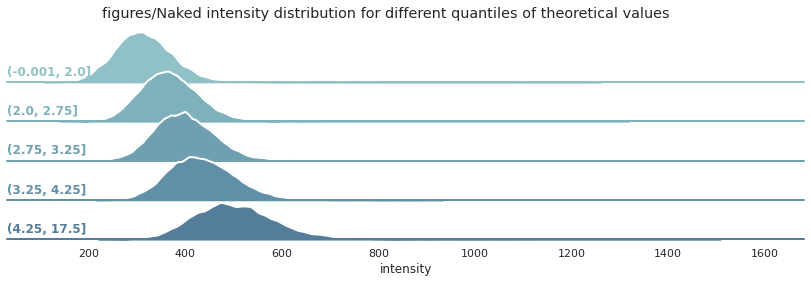

<IPython.core.display.Javascript object>

In [27]:
long_form_naked_data = generate_df_for_theo_correlation_comparison(
    naked.data.copy(), theo.data
)
fg = show_ridge_plot(long_form_naked_data, name="naked")

This pretty-looking plot shows a few interesting things about the naked data:

1. The SNR is quite low. Having very low concentration of sites still results in an intensity value of a few hundreds, and adding a lot more sites (5+) only increases this 'affinity' two-fold.
2. The high degree of overlap between the distributions may point us towards issues with the data acquisition. The data might be changing too rapidly for the microscope to detect, generating some sort of a bleed-through between the different  quantiles.
3. Nonetheless, the correlation between the site density and the intensity is definitely there, which is great.
4. The data is stretching towards the right due to a few high values in the higher quantiles. They're probably meaningless.

We can also think of doing the same analysis to the chromatin data, and look for possible differences.

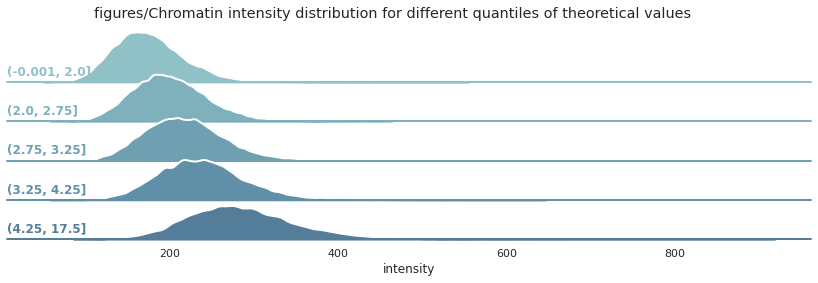

<IPython.core.display.Javascript object>

In [28]:
long_form_eco_data = generate_df_for_theo_correlation_comparison(
    eco.data.copy(), theo.data
)
fg = show_ridge_plot(long_form_eco_data, name="chromatin")

This plot is very similar to the naked one, but with lower absolute intensity values and a smaller difference between the peaks. It seems that indeed some of the DNA is hidden behind chromatin.

### Naked data normalization

The naked data is now ready to be normalized using the "improved" theoretical data. This normalization step occurs in `subtract_background_with_theo` and in `normalize_by_site_density` and consists of two steps:
1. **Subtract the background noise.** We identify noise as loci where the theoretical data insists that no Eco sites exist, but the naked data is still showing some readings. This necessarily means that we hit the noise floor, and we can subtract that value without concern. As seen in the histogram below, the noise is noisy, which means that the noise floor isn't contained to a single intensity value. A conservative approach that is applied here is to use the mean value of that Gaussian as the background noise, and clip the data at that value - i.e. all values at or below this value are zeroed.
2. **Normalize by site density.** We should also take into account the distribution of site density when observing the naked data. A simple approach is to divide the naked intensity by the theoretical value. Higher densities will lower the the intensity values, while lower ones will increase it. The function `normalize_by_site_density` does exactly that, but we'll only use it on the accessability map, which is the dataset that is created after finding the correlation between the naked data and the chromatin one. This is because the ridge plots we saw above, the ones which show the Eco\Naked distribution as a function of the theoretical data, show that it this normalization is not as important as you might think.

At this point we're only subtracting the BG from the naked data. We'll run the normalization step later.

In [29]:
naked.data = subtract_background_with_theo(naked.data, theo.data)

<IPython.core.display.Javascript object>

### Chromatin and naked normalization

The next step is to compare the chromatin and naked data to the ATAC in order for us to find areas with similarities. We do that by first equalizing the distributions of the naked and chromatin data to those of the ATAC using the `equalize_distribs` function. This means that we spread them, in a linear fashion, over the same set of values.

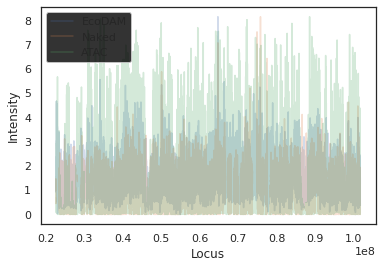

<IPython.core.display.Javascript object>

In [30]:
eco_and_naked = equalize_distribs([eco.data.drop("chr", axis=1), naked.data], atac.data)
eco_no_min, naked_no_min = eco_and_naked[0], eco_and_naked[1]
ax = plot_bg(eco_no_min, naked_no_min, atac.data)

### Seeding and expansion

The question that remains unanswered is how to compare the ATAC and chromatin tracks. We eventually wish to find close and open areas in the genome, and for that we should use every piece of data we possess. As a start, we'll use _seeding_ to identify similar looking regions. 

Seeds are areas that show a large similarity in the track's shape between the Eco and ATAC data. To find them, we subtract the now-equalized traces and look for the smallest differences. These points are the seeds, and we expand them by some amount to identify whether this similarity was accidental or whether it truly reflects the underlying data.

Interestingly, when looking at seeds from the Eco data they should usually point to areas with an open DNA, but the naked seeds should be scattered around all over the place, since all of the genome was open. Thus we might look for the distribution of events over the loci instead of at the values themselves.

In [48]:
closest_eco, closest_atac_eco = find_closest_diff(
    eco_no_min.loc[:, "intensity"].copy(), atac.data.loc[:, "intensity"].copy()
)
closest_naked, closest_atac_naked = find_closest_diff(
    naked.data.intensity.copy(), atac.data.intensity.copy()
)
clusters_eco = expand_seeds(closest_eco.copy())
clusters_naked = expand_seeds(closest_naked.copy())
clustered_eco, clustered_atac_eco = concat_clusters(
    eco_no_min.copy(), atac.data.copy(), clusters_eco.copy()
)
clustered_naked, clustered_atac_naked = concat_clusters(
    naked.data.copy(), atac.data.copy(), clusters_naked.copy()
)
write_intindex_to_disk(
    closest_atac_eco,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_eco.bedgraph"
    ),
)
write_intindex_to_disk(
    closest_atac_naked,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_naked.bedgraph"
    ),
)
write_intindex_to_disk(
    closest_eco,
    eco_fname.parent.with_name(
        "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_seeds_top_similarities_with_atac.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_eco,
    eco_fname.parent.with_name(
        "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_seeds_top_similarities_with_atac_after_expansion.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_atac_eco,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_eco_after_expansion.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_atac_naked,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_naked_after_expansion.bedgraph"
    ),
)
write_intindex_to_disk(
    closest_naked,
    naked_fname.parent.with_name(
        "NakedAF647_channel2_chr15_NoMissingChromatinWin_no_background_seeds_top_similarities_with_atac.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_naked,
    naked_fname.parent.with_name(
        "NakedAF647_channel2_chr15_NoMissingChromatinWin_no_background_seeds_top_similarities_with_atac_after_expansion.bedgraph"
    ),
)

<IPython.core.display.Javascript object>

In [ ]:
normed_naked = normalize_df_between_01(naked.data.copy())
normed_eco = normalize_df_between_01(eco_no_min.copy())
sub = normed_eco - normed_naked
write_intindex_to_disk(
    sub.dropna(),
    naked_fname.parent.with_name("eco_after_naked_subtraction.bedgraph"),
)